In [90]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
df = pd.read_csv('../../data/process_v1/process_data_6.csv')
df = df[df['city'] == 0]

In [92]:
df['is_street_house'] = (df['accessibility'] == 'notInTheAlley').astype(np.int32)

In [93]:
{'fitThreeCars': 0,
 'fitOneCarAndOneMotorbike': 1,
 'notInTheAlley': 2,
 'parkCar': 3,
 'theBottleNeckPoint': 4,
 'fitTwoCars': 5,
 'narrorRoad': 6}

{'fitThreeCars': 0,
 'fitOneCarAndOneMotorbike': 1,
 'notInTheAlley': 2,
 'parkCar': 3,
 'theBottleNeckPoint': 4,
 'fitTwoCars': 5,
 'narrorRoad': 6}

In [94]:
cat_cols = ['is_street_house', 'administrative_genre', 'city', 'ward', 'street', 'district', 'typeOfRealEstate', 'houseDirection', 'accessibility', 'certificateOfLandUseRight'] + [c for c in df.columns.tolist() if '_lat' in c or '_lon' in c]
target_cols = ['target']
remove_cols = ['price', 'description', 'city'] + [c for c in df.columns if 'distance_hcm' in c]
num_cols = [c for c in df.columns.tolist() if c not in (cat_cols + target_cols + remove_cols)]

cat_cols = list(set(cat_cols))
target_cols = list(set(target_cols))
remove_cols = list(set(remove_cols))
num_cols = list(set(num_cols))

print(len(cat_cols), len(target_cols), len(remove_cols), len(num_cols))

30 1 55 149


In [95]:
cat_cols

['nearest_4_lon',
 'nearest_2_lat',
 'accessibility',
 'nearest_6_lat',
 'district_lat',
 'nearest_1_lon',
 'street',
 'nearest_3_lon',
 'certificateOfLandUseRight',
 'nearest_8_lon',
 'nearest_5_lat',
 'city',
 'district_lon',
 'houseDirection',
 'nearest_0_lat',
 'nearest_0_lon',
 'administrative_genre',
 'is_street_house',
 'nearest_5_lon',
 'nearest_1_lat',
 'nearest_6_lon',
 'nearest_3_lat',
 'ward',
 'nearest_7_lat',
 'typeOfRealEstate',
 'nearest_7_lon',
 'nearest_8_lat',
 'nearest_4_lat',
 'nearest_2_lon',
 'district']

In [96]:
num_cols

['distance_hn_Hồ Ngọc Khánh',
 'num_of_fast_food_in_2000m_radius',
 'num_of_marketplace_in_1000m_radius',
 'nearest_0_district',
 'num_of_school_in_2000m_radius',
 'num_of_atm_in_500m_radius',
 'distance_hn_Aeon Mall Long Biên',
 'num_of_police_in_2000m_radius',
 'distance_hn_Lotte Center Hanoi',
 'nearest_6_district',
 'nearest_5_ward',
 'num_of_place_of_worship_in_2000m_radius',
 'nearest_2_district',
 'distance_hn_Hồ Tây 3',
 'num_of_place_of_worship_in_1000m_radius',
 'nearest_4_street',
 'num_of_university_in_500m_radius',
 'nearest_3_district',
 'acreage',
 'distance_hn_Hồ Gươm',
 'distance_hn_Hàng Hành',
 'num_of_cafe_in_500m_radius',
 'num_of_place_of_worship_in_500m_radius',
 'distance_hn_Trung tâm thương mại Hà Nội Keangnam',
 'num_of_restaurant_in_500m_radius',
 'num_of_kindergarten_in_1000m_radius',
 'density',
 'distance_hn_Công viên nước Hồ Tây',
 'nearest_3_street',
 'nearest_5_district',
 'num_of_bank_in_2000m_radius',
 'num_of_university_in_1000m_radius',
 'num_of_park

In [97]:
print(len(num_cols))

149


In [98]:
train_independent_corr = df[num_cols].corr()
train_seleted_corr_columns = np.full((train_independent_corr.shape[0],), True, dtype=bool)
for i in range(train_independent_corr.shape[0]):
    for j in range(i + 1, train_independent_corr.shape[0]):
        if train_independent_corr.iloc[i, j] >= 0.99:

            if train_seleted_corr_columns[j]:
                train_seleted_corr_columns[j] = False
train_selected_columns = df[num_cols].columns[train_seleted_corr_columns]
print(train_selected_columns.shape)

(132,)


In [99]:
# train_selected_columns = list(train_selected_columns)
train_selected_columns = num_cols

In [100]:
df[cat_cols] = df[cat_cols].fillna(100)
df[cat_cols] = df[cat_cols].astype(np.int32)

In [101]:
df = df[cat_cols + num_cols + target_cols]

In [102]:
df = df[df[target_cols[0]] != np.inf]
df = df[df[target_cols[0]] != -np.inf]

In [103]:
df = df[df[target_cols[0]] >= 10]
df = df[df[target_cols[0]] < 100 * 12]

In [104]:
categorical_features_indices = [i for i, c in enumerate(df.columns.tolist()) if c in cat_cols]

In [105]:
X = df.drop(target_cols[0], axis=1)
y = df[target_cols[0]] / 100

In [106]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(98724, 179) (98724,)
(10970, 179) (10970,)


In [107]:
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [108]:
model = CatBoostRegressor(verbose=100, iterations = 5000, task_type='GPU', devices = '0:1')
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    logging_level='Verbose',
    # plot=True
)

Learning rate set to 0.064462
0:	learn: 1.2672576	test: 1.2598068	best: 1.2598068 (0)	total: 24.6ms	remaining: 2m 3s
100:	learn: 0.6113266	test: 0.6096552	best: 0.6096552 (100)	total: 2.17s	remaining: 1m 45s
200:	learn: 0.5866314	test: 0.5934819	best: 0.5934819 (200)	total: 4.35s	remaining: 1m 43s
300:	learn: 0.5710289	test: 0.5854071	best: 0.5853908 (299)	total: 6.55s	remaining: 1m 42s
400:	learn: 0.5604143	test: 0.5796100	best: 0.5796100 (400)	total: 8.76s	remaining: 1m 40s
500:	learn: 0.5508926	test: 0.5739898	best: 0.5739898 (500)	total: 10.9s	remaining: 1m 38s
600:	learn: 0.5435487	test: 0.5712090	best: 0.5712090 (600)	total: 13.1s	remaining: 1m 36s
700:	learn: 0.5369138	test: 0.5679927	best: 0.5679545 (698)	total: 15.3s	remaining: 1m 34s
800:	learn: 0.5309810	test: 0.5659661	best: 0.5659661 (800)	total: 17.5s	remaining: 1m 31s
900:	learn: 0.5253329	test: 0.5633990	best: 0.5633990 (900)	total: 19.7s	remaining: 1m 29s
1000:	learn: 0.5205391	test: 0.5623636	best: 0.5623604 (999)	tot

In [109]:
feature_importances = pd.DataFrame(model.get_feature_importance(),columns=['importance'])
feature = pd.DataFrame(df.columns,columns=['feature'])
feature_importance_df = pd.concat([feature_importances,feature],axis=1)
feature_importance_df

,importance,feature
0,0.000000,nearest_4_lon
1,0.070897,nearest_2_lat
2,3.082488,accessibility
3,0.069017,nearest_6_lat
4,0.000000,district_lat
...,...,...
175,0.218540,nearest_2_street
176,0.144709,num_of_parking_in_1000m_radius
177,0.329623,facade
178,0.317126,endWidth


Text(0.5, 1.0, 'Feature Importances ')

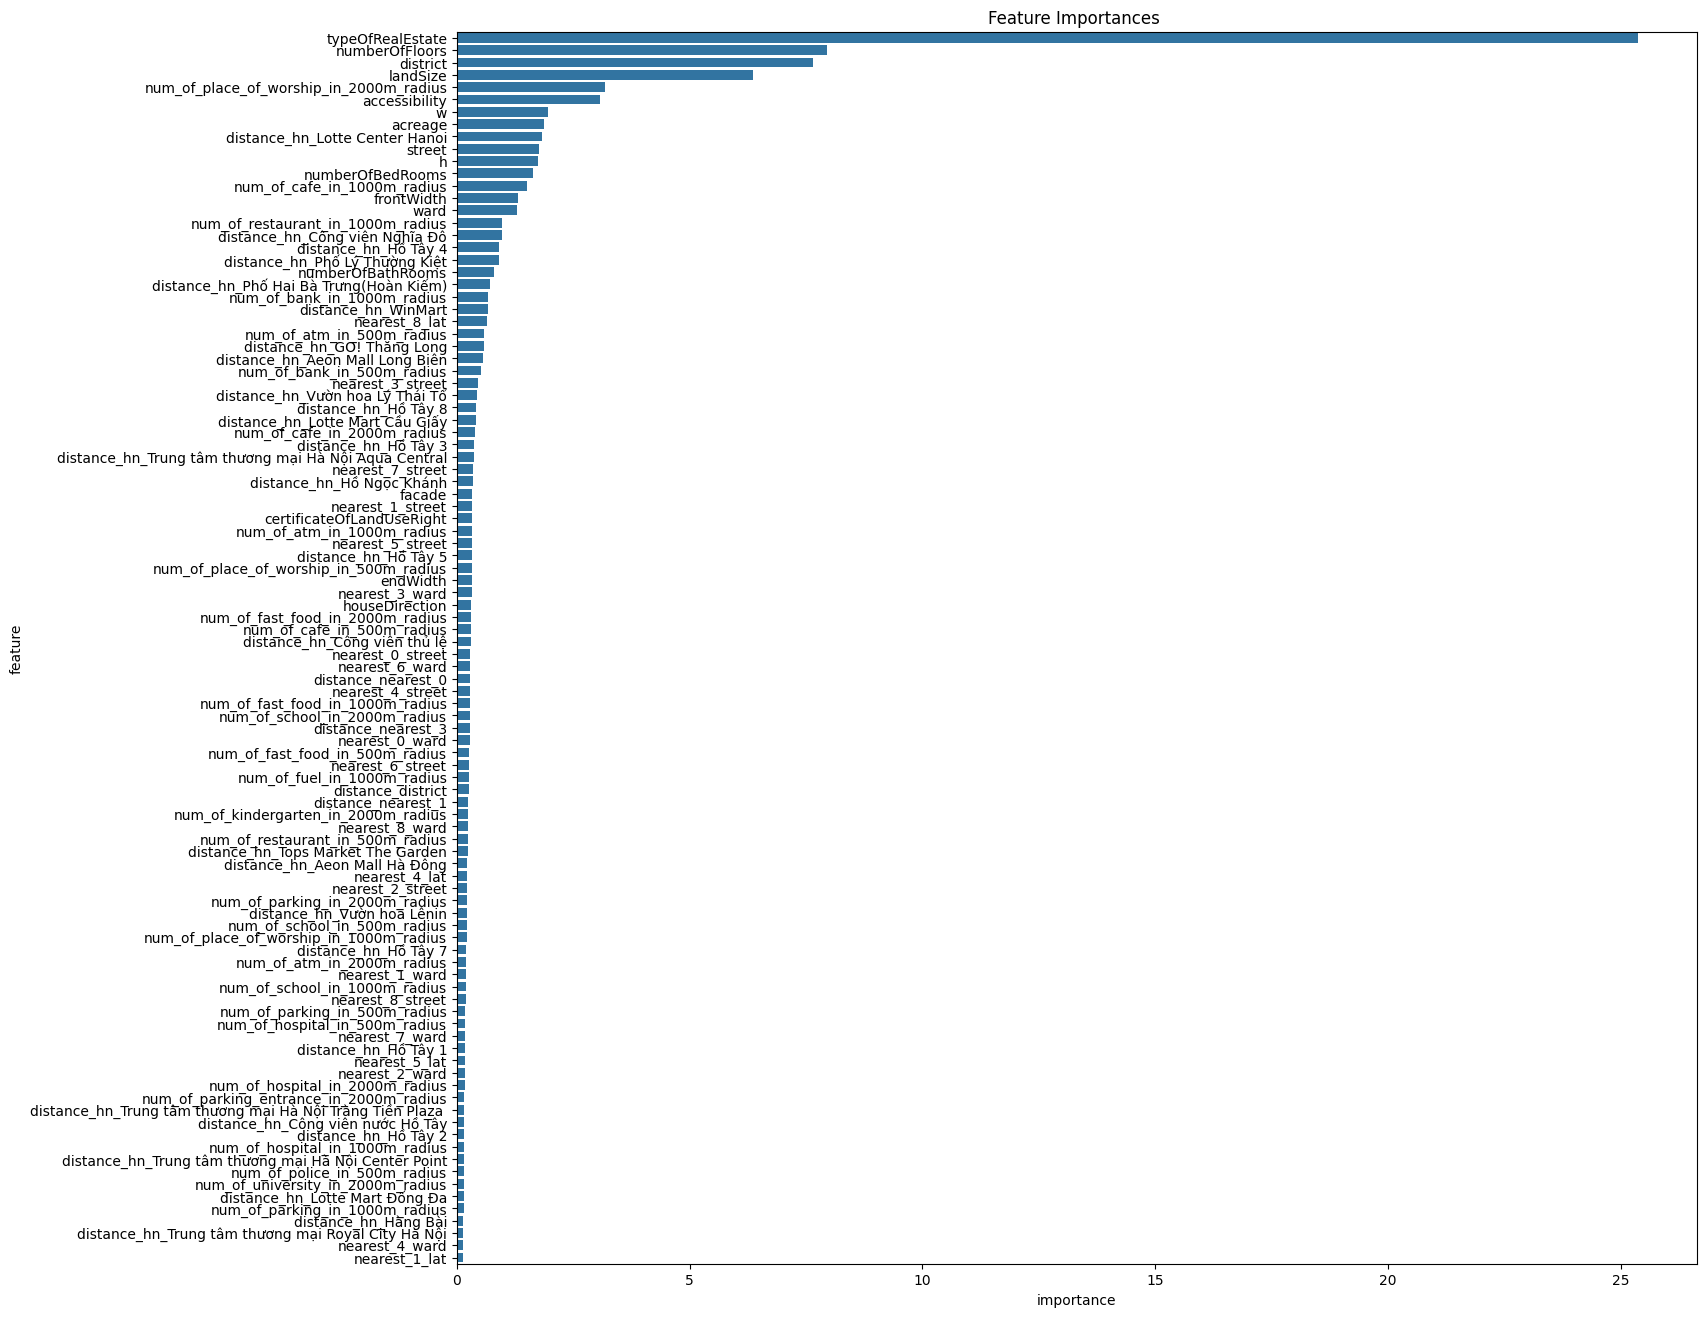

In [110]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance_df.sort_values(by='importance', ascending=False).head(100), x='importance', y='feature')
plt.title('Feature Importances ')

In [111]:
model.predict(X_validation)

array([1.24298236, 1.17671914, 4.03197545, ..., 0.26927496, 2.49014503,
       1.4637997 ])